# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 12.10.2024

Мягкий дедлайн: 23:59MSK 27.10.2024

Жесткий дедлайн: 23:59MSK 31.10.2024

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [1]:
!pip install folium

In [2]:
import folium

m = folium.Map(location=(50.97178, 9.79418), zoom_start=15)

m

Если вы всё сделали правильно, то выше должна открыться карта

### 📌 **Памятка по дз2**

Обрабатывать данные можно любым способом (`polars`, `pandas`, `pyspark`, ...), который вам нравится и запускается в ноутбуке, и любой библиотекой для визуализации (`matplotlib`, `seaborn`, `plotly`, ...). Пользуйтесь на здоровье, но!

> Учтите, что `polars` всё ещё молодой и не все библиотеки его поддерживают. `sklearn` во многом уже работает, но на всякий случай не стесняйтесь пользоваться методами `pl.DataFrame.to_pandas()` или `pl.DataFrame.to_numpy()`    

> Впрочем, `pandas` тоже не лишён проблем. `sklearn` принимает `pd.DataFrame` почти везде, проблемы очень редки, но если вдруг возникнет какая-то беда с шейпами, или ещё какой-нибудь казус, а вы уверены, что всё правильно, пользуйтесь `pd.DataFrame.to_numpy()`. Это не всегда решает проблему, но часто помогает понять, что на самом деле не так. При желании можно передавать и `Iterable`, и sparse-матрицы

> Графики должны быть понятные, читаемые и пр. Консультируйтесь с памяткой из дз1 в задании на график

> Для воспроизводимости результатов не забывайте пользоваться `np.random.seed(...)`, при необходимости чистите мусор `gc.collect()`, лучше в каждой ячейке

> Все результаты должны быть получены в ноутбуке. На каждый **Вопрос** долен быть дан **Ответ** (письменно (в Markdown например) или кодом)

In [3]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Lasso

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [5]:
train = pd.read_csv("train.csv", engine="python")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")

In [6]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [7]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [8]:
sample.head()

,id,trip_duration
0,id3004672,959
1,id3505355,959
2,id1217141,959
3,id2150126,959
4,id1598245,959


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [9]:
train = train.drop('dropoff_datetime', axis = 1)

In [10]:
import datetime
train.dtypes

,0
id,object
vendor_id,int64
pickup_datetime,object
passenger_count,int64
pickup_longitude,float64
pickup_latitude,float64
dropoff_longitude,float64
dropoff_latitude,float64
store_and_fwd_flag,object
trip_duration,int64


In [11]:
train[['pickup_datetime']] = train[['pickup_datetime']].astype('datetime64[ns]')
train.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435


В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

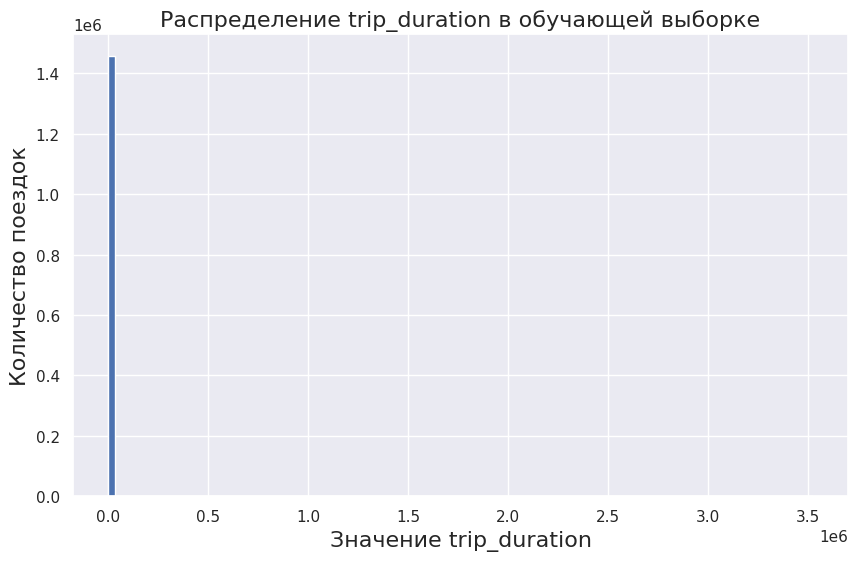

In [12]:
plt.figure(figsize = (10, 6))
plt.hist(train['trip_duration'], bins=100)
plt.xlabel('Значение trip_duration', fontsize=16)
plt.ylabel('Количество поездок', fontsize=16)
plt.title('Распределение trip_duration в обучающей выборке', fontsize=16)
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [13]:
train['log_trip_duration'] = np.log1p(train['trip_duration'].to_numpy())
train = train.drop('trip_duration', axis = 1)

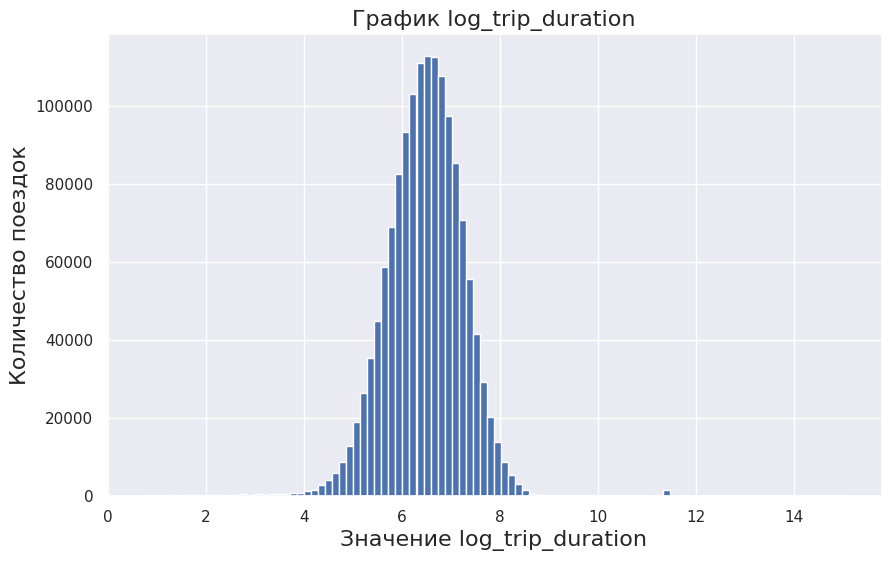

In [14]:
plt.figure(figsize = (10, 6))
plt.hist(train['log_trip_duration'], bins=100)
plt.xlabel('Значение log_trip_duration', fontsize=16)
plt.ylabel('Количество поездок', fontsize=16)
plt.title('График log_trip_duration', fontsize=16)
plt.show()

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [15]:
rmsle_best_const = 0.79575
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)


0.79575


In [16]:
#def rmsle(log1p_y_true, log1p_y_pred):
    #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    #raise NotImplementedError

#rmsle_best_const = ...
#print(rmsle_best_const)
#assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году:

In [17]:
train['date'] = [d.date() for d in train["pickup_datetime"]]

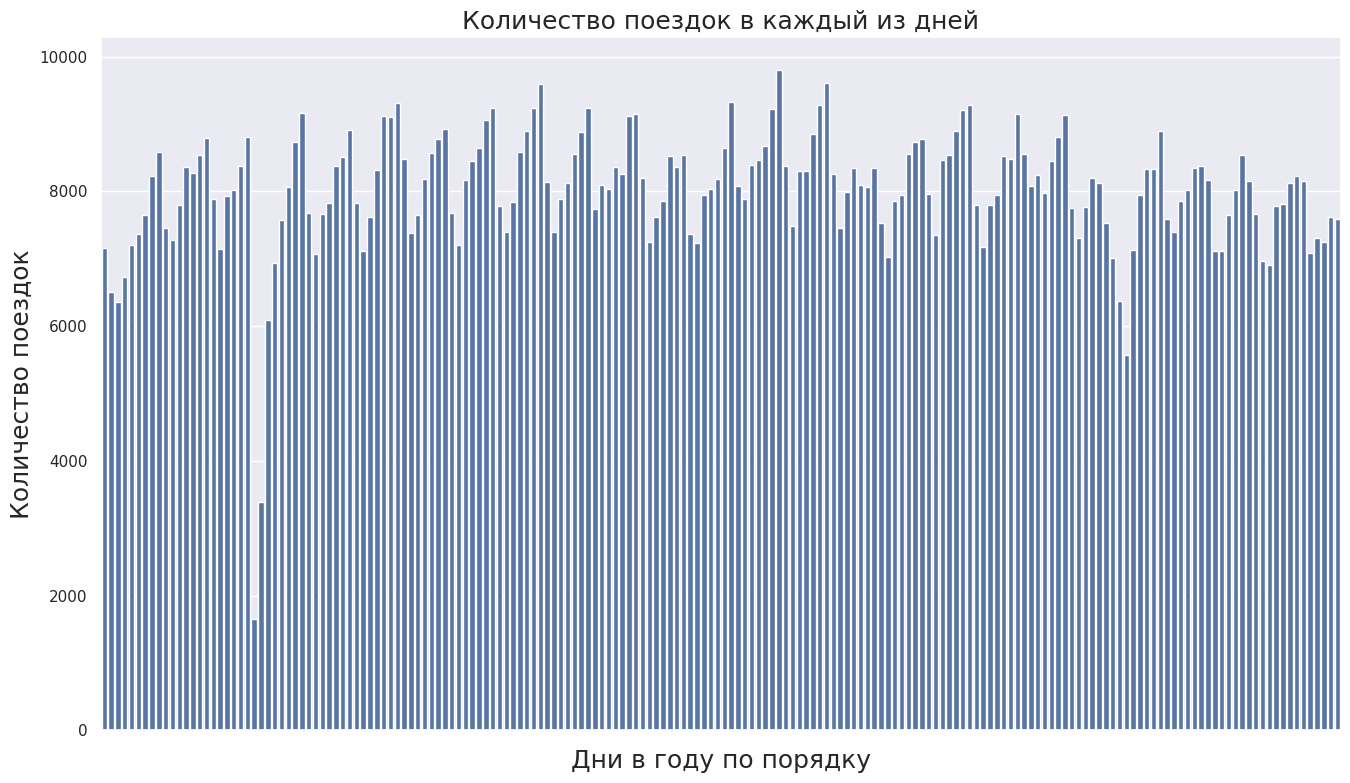

In [18]:

plt.figure(figsize = (16, 9))
g = sns.countplot(x = train.sort_values(by = 'date')['date'])
g.set_xticklabels(np.arange(0))
plt.xlabel('Дни в году по порядку', fontsize=18)
plt.ylabel('Количество поездок', fontsize=18)
plt.title('Количество поездок в каждый из дней', fontsize=18)
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках:

конец января - ледяная буря

(англ. Memorial Day) — национальный день памяти США, отмечаемый ежегодно в последний понедельник мая.

Он посвящён памяти американских военнослужащих, погибших во всех войнах и вооружённых конфликтах, в которых США когда-либо принимали участие.

In [19]:
train['weekday'] = [d.weekday() for d in train["pickup_datetime"]]
train['hour'] = [d.strftime('%H') for d in train["pickup_datetime"]]
train

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,date,weekday,hour
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,2016-03-14,0,17
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,2016-06-12,6,00
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,2016-01-19,1,11
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785,2016-04-06,2,19
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642,2016-03-26,5,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,N,6.658011,2016-04-08,4,13
1458640,id1049543,1,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,N,6.486161,2016-01-10,6,07
1458641,id2304944,2,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,N,6.639876,2016-04-22,4,06
1458642,id2714485,1,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,N,5.924256,2016-01-05,1,15


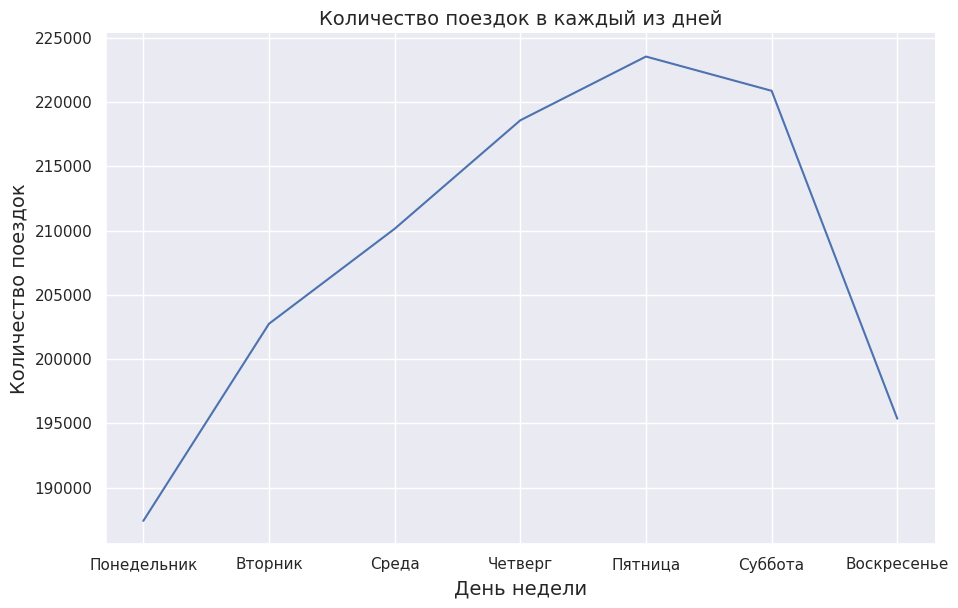

In [20]:
g = sns.relplot(data=train.groupby("weekday").count(),
                x=train.groupby("weekday").count().index,
                y="id",
                kind="line",
                height=6, aspect=8/5)
plt.xlabel('День недели', fontsize=14)
plt.ylabel('Количество поездок', fontsize=14)
plt.title('Количество поездок в каждый из дней', fontsize=14)
plt.xticks(np.arange(7), labels=['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'])
plt.show()

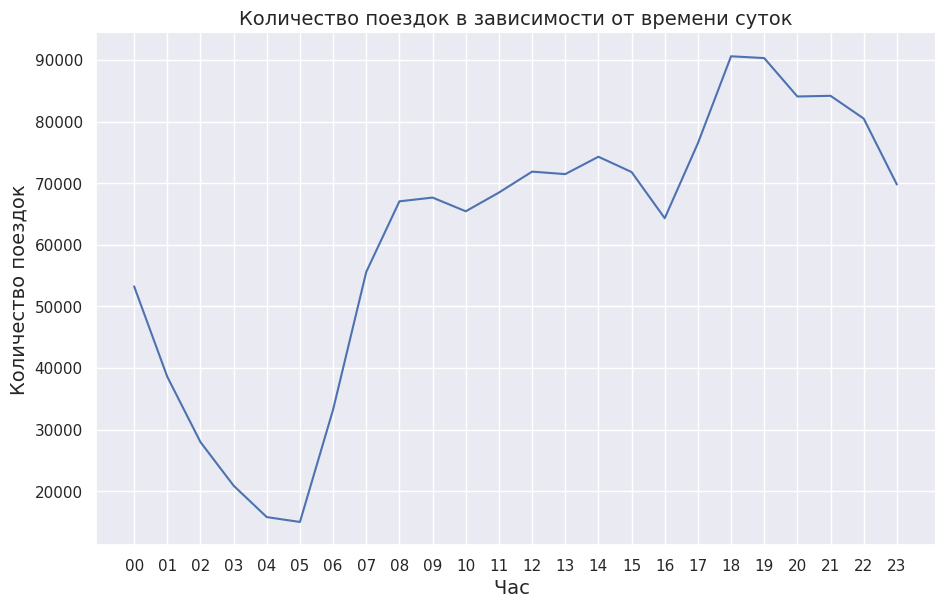

In [21]:
g = sns.relplot(data=train.groupby("hour").count(),
                x=train.groupby("hour").count().index,
                y="id",
                kind="line",
                height=6, aspect=8/5)
plt.xlabel('Час ', fontsize=14)
plt.ylabel('Количество поездок', fontsize=14)
plt.title('Количество поездок в зависимости от времени суток', fontsize=14)
plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, поищите, как это делается). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

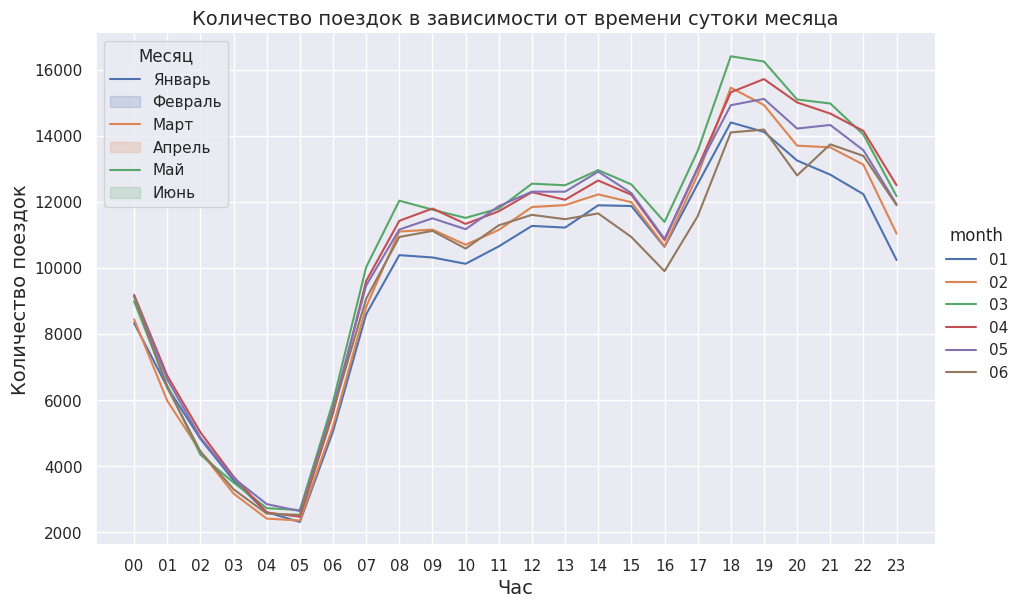

In [22]:
train['month'] = [d.strftime('%m') for d in train["pickup_datetime"]]
g = sns.relplot(data=train.groupby(["month", "hour"]).count().reset_index(),
                x='hour',
                y="id",
                hue='month',
                kind="line",
                height=6, aspect=8/5)
plt.xlabel('Час', fontsize=14)
plt.ylabel('Количество поездок', fontsize=14)
plt.title('Количество поездок в зависимости от времени сутоки месяца', fontsize=14)
plt.legend(title='Месяц', labels=['Январь','Февраль', 'Март', 'Апрель', 'Май', 'Июнь'])
plt.show()

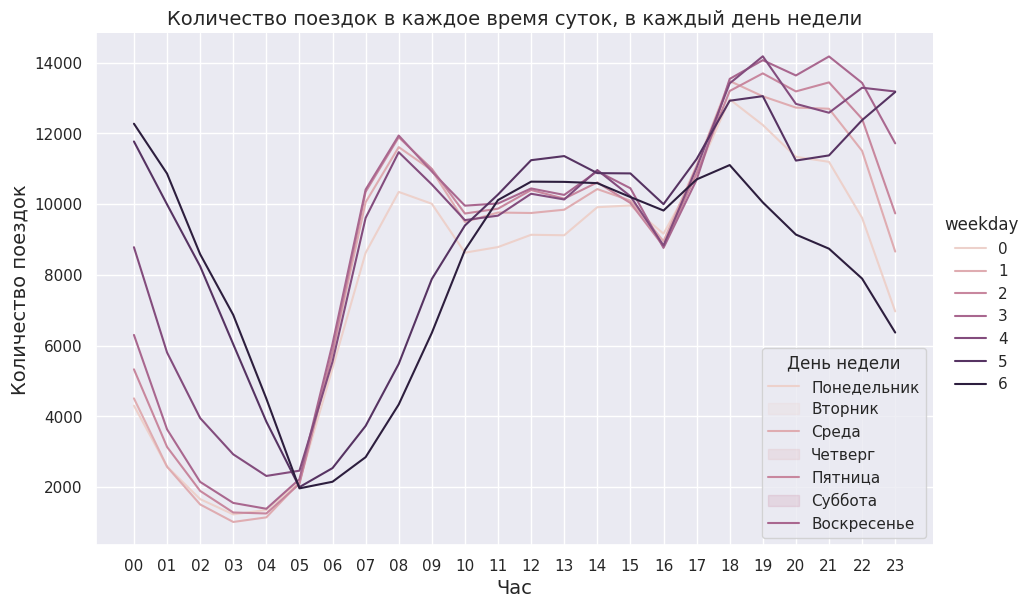

In [23]:
g = sns.relplot(data=train.groupby(["weekday", "hour"]).count().reset_index(),
                x='hour',
                y="id",
                hue='weekday',
                kind="line",
                height=6, aspect=8/5)
plt.xlabel('Час', fontsize=14)
plt.ylabel('Количество поездок', fontsize=14)
plt.title('Количество поездок в каждое время суток, в каждый день недели', fontsize=14)
plt.legend(title='День недели', labels=['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'])
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

В выходные дни людям не надо ездить на работу, поэтому количество поездок на такси меньше, что видно на графике. От месяца к месяцу колчество поездок на такси меняется незначительно.По времени суток можно определить, что количество поездок на такси увеличивается в часы, когда нужн ехать на работу или с работы.



**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [24]:
from sklearn.model_selection import train_test_split
mtr_tain, mtr_test = train_test_split(train, test_size=0.3, random_state=10)

In [25]:
train["log_trip_duration"] = pd.to_numeric(train["log_trip_duration"], errors="coerce")
train = train.dropna(subset=["log_trip_duration"])


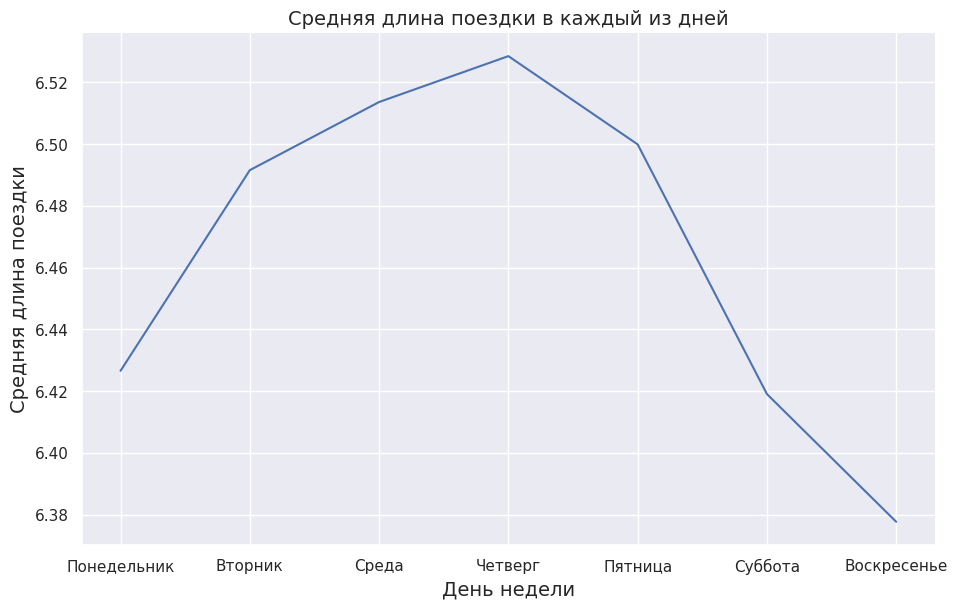

In [26]:

grouped_data = train.groupby("weekday").agg(
    mean_log_trip_duration=("log_trip_duration", "mean"),
    count_log_trip_duration=("log_trip_duration", "count")
)

g = sns.relplot(
    data=grouped_data,
    x=grouped_data.index,
    y="mean_log_trip_duration",
    kind="line",
    height=6,
    aspect=8/5
)

plt.xlabel('День недели', fontsize=14)
plt.ylabel('Средняя длина поездки', fontsize=14)
plt.title('Средняя длина поездки в каждый из дней', fontsize=14)
plt.xticks(
    np.arange(7),
    labels=['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
)
plt.show()


In [27]:
train["log_trip_duration"] = pd.to_numeric(train["log_trip_duration"], errors="coerce")
train = train.dropna(subset=["log_trip_duration"])


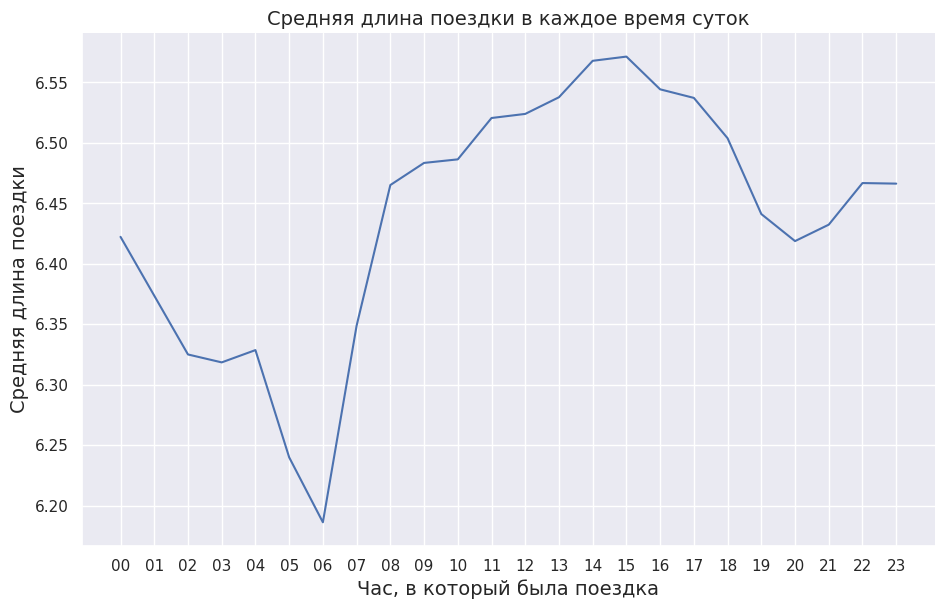

In [28]:

grouped_data = train.groupby("hour")["log_trip_duration"].mean()

g = sns.relplot(
    data=grouped_data.reset_index(),
    x="hour",
    y="log_trip_duration",
    kind="line",
    height=6,
    aspect=8/5
)

plt.xlabel('Час, в который была поездка', fontsize=14)
plt.ylabel('Средняя длина поездки', fontsize=14)
plt.title('Средняя длина поездки в каждое время суток', fontsize=14)
plt.show()


**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Да, графики похожи.
На графиках видно, что средняя длина поездки имеет похожие тенденции по сравнению с количеством поездок, которые часто достигают пика в рабочие дни и снижаются к выходным. Это может объясняться тем, что по будням люди чаще совершают поездки, например, по делам, что приводит к большему количеству и более длинным поездкам. В выходные средняя длина поездки снижается, поскольку потребность в длительных поездках меньше.

На графике зависимости длины поездки от часа суток наблюдается интересный тренд: ранние утренние часы показывают пониженную длину поездки, а затем, начиная с 7-8 часов утра, длина поездки возрастает, достигая пика в дневное время, и затем постепенно снижается к вечеру. Это совпадает с пиковыми часами поездок, связанными с рабочими и учебными днями.

В аномальные периоды (например, ранние утренние часы и ночное время) средняя длина поездки снижается. Это может быть связано с тем, что ночью и ранним утром в основном совершаются короткие поездки, такие как поездки домой или до ближайшего места назначения.

Что касается тренда на графике зависимости `log_trip_duration` от номера дня в году, такой тренд может проявляться в зависимости от сезонных факторов: в определенные периоды года длина поездок может увеличиваться (например, летом, когда больше туристов или отпусков), а в другие периоды, наоборот, снижаться.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [29]:
train['date'] = [d.date() for d in train["pickup_datetime"]] #чтобы не было проблем с повторным запуском
train['situation1'] = 0
train['situation2'] = 0
train.loc[(train['date'] > datetime.date(2016, 1, 21)) & (train['date'] < datetime.date(2016, 1, 29)), 'situation1'] = 1
train.loc[(train['date'] > datetime.date(2016, 5, 26)) & (train['date'] < datetime.date(2016, 6, 2)), 'situation2'] = 1

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [30]:
y = train["log_trip_duration"]
X = train.drop(columns=["log_trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
categorical = ["hour", "weekday", "month", "date", "situation1", "situation2"]
numeric_features = []

In [31]:

categorical = ["hour", "weekday", "date", "situation1", "situation2"]

y = train["log_trip_duration"]
X = train.drop(columns=["log_trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))


Test RMSE = 0.7865


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [97]:
from typing import Iterable
import folium
import numpy as np
import pandas as pd

def show_circles_on_map(
    latitude_values: Iterable[float],
    longitude_values: Iterable[float],
    color: str = "blue",
) -> folium.Map:
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    Works best on samples of size < 10k, too costly otherwise

    latitude_values: sample latitude values of a dataframe
    longitude_values: sample longitude values of a dataframe
    color: the color of circles to be drawn
    """

    location = (np.mean(latitude_values), np.mean(longitude_values))
    m = folium.Map(location=location)

    for lat, lon in zip(latitude_values, longitude_values):
        folium.Circle(
            radius=100,
            location=(lat, lon),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

sample_df = df.sample(1000)  # Случайная выборка из 1000 строк
show_circles_on_map(
    sample_df['pickup_latitude'].values,
    sample_df['pickup_longitude'].values,
    "blue"
)


Напишите функция, которая вернет значения колонок `pickup_latitude`, `pickup_longitude` на каком-нибудь разумном кусочке датафрейма, например, `df.sample(1000)` и покажите на карте, используя `show_circles_on_map`

In [98]:


show_circles_on_map(
    sample_df['dropoff_latitude'].values,
    sample_df['dropoff_longitude'].values,
    "blue"
)

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

Это должны быть два аэропорта, мы их выбрали как наиболее частые точки назначения и отправные точки для такси

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [35]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

train.loc[:, 'haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [36]:
train['log_haversine'] = np.log1p(train['haversine'].to_numpy())

Посчитайте корреляцию и убедитесь, что логарифм расстояния лучше отражает таргет, чем просто расстояние:

In [37]:
print('Корреляция log_haversine и log_trip_duration равна', train[['log_haversine', "log_trip_duration"]].corr().iloc[0, 1])
print('Корреляция haversine и log_trip_duration равна', train[['haversine', "log_trip_duration"]].corr().iloc[0, 1])

Корреляция log_haversine и log_trip_duration равна 0.7498822373942582
Корреляция haversine и log_trip_duration равна 0.5735948311180327


**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

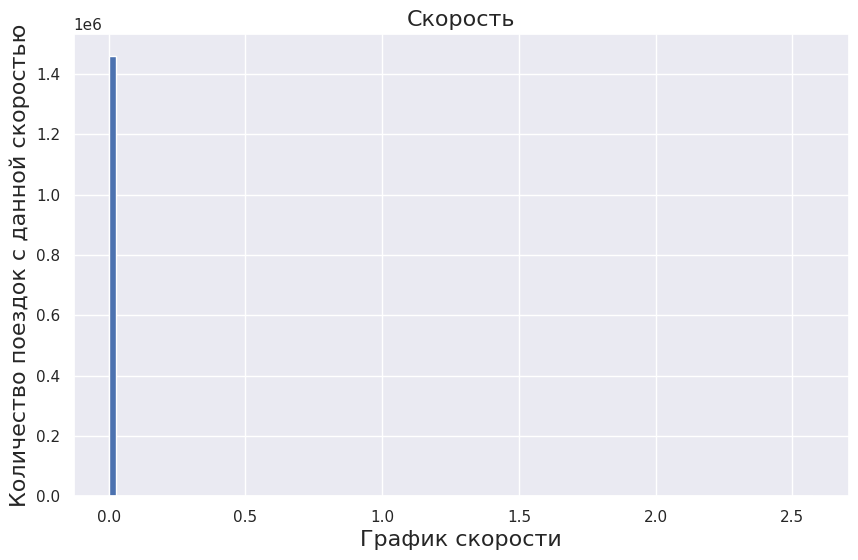

In [38]:
plt.figure(figsize = (10, 6))
plt.hist(train['haversine'] / np.expm1(train['log_trip_duration']), bins=100)
plt.xlabel('График скорости', fontsize=16)
plt.ylabel('Количество поездок с данной скоростью', fontsize=16)
plt.title('Скорость', fontsize=16)
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

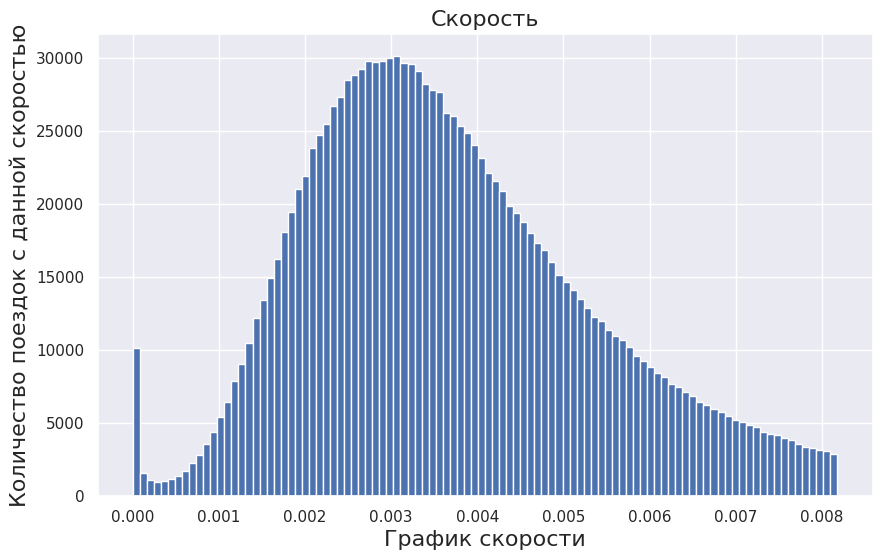

In [39]:
train['speed'] = train['haversine'] / np.expm1(train['log_trip_duration'])
plt.figure(figsize = (10, 6))
plt.hist(train["speed"][train["speed"] < np.quantile(train["speed"], 0.95)], bins=100)
plt.xlabel('График скорости', fontsize=16)
plt.ylabel('Количество поездок с данной скоростью', fontsize=16)
plt.title('Скорость', fontsize=16)
plt.show()

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте Heatmap-график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

Text(91.25, 0.5, 'День недели')

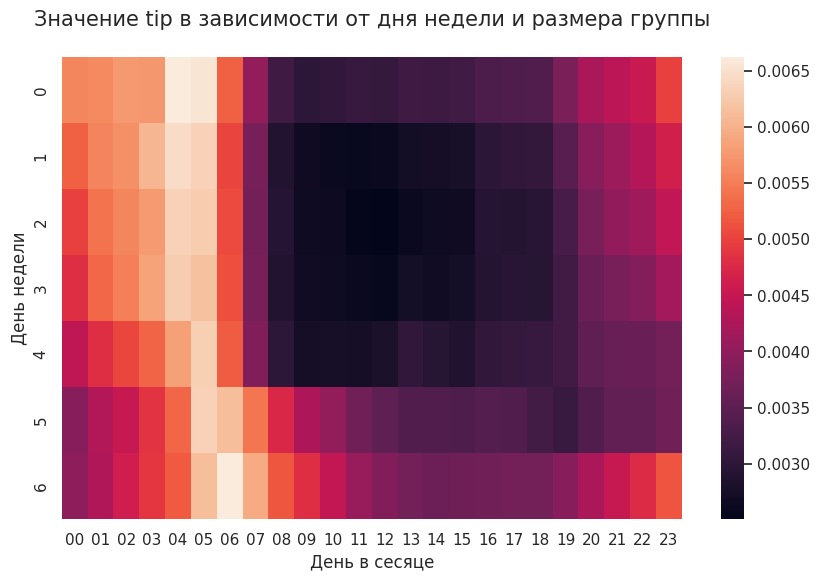

In [40]:
dk = train[['weekday', 'hour', 'speed']].groupby(['weekday', 'hour']).median()
ds = pd.pivot_table(data=dk, index='weekday', columns='hour', values='speed')
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.heatmap(ds, ax=ax);

ax.set_title('Значение tip в зависимости от дня недели и размера группы\n', fontsize=15)
ax.set_xlabel('День в месяце', fontsize=12)
ax.set_ylabel('День недели', fontsize=12)

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

Значение скорости, вычисленное на основе данных о продолжительности поездки и расстояния между точками посадки и высадки, не стоит использовать как признак для обучения, потому что оно является производным показателем, получаемым напрямую из целевой переменной — продолжительности поездки. Если использовать его как входной признак в модели, то это приведет к утечке данных (data leakage), так как модель получит информацию о целевой переменной, что нарушит чистоту обучения.

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Скорость минимальна, когда близка к 0, и максимальна при значении около 0.008, хотя такие значения встречаются реже.



Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [41]:
train['jam'] = 0
train['free'] = 0
train.loc[(train['hour'] == '08')
          & ((train['weekday'] >= 1) & (train['weekday'] <= 4))
          , "jam"] = 1
train.loc[((train['hour'] >= '18') & (train['hour'] <= '21'))
          & ((train['weekday'] >= 0) & (train['weekday'] <= 5))
          , "jam"] = 1
train.loc[((train['hour'] == '22') | (train['hour'] == '23'))
          & (train['weekday'] == 5)
          , "jam"] = 1
train.loc[((train['hour'] == '00') | (train['hour'] == '01'))
          & ((train['weekday'] == 6) | (train['weekday'] == 7))
          , "jam"] = 1
train.loc[((train['hour'] >= '01') & (train['hour'] <= '06'))
          & ((train['weekday'] >= 0) & (train['weekday'] <= 4))
          , "free"] = 1
train.loc[((train['hour'] >= '04') & (train['hour'] <= '09'))
          & ((train['weekday'] >= 5) & (train['weekday'] <= 6))
          , "free"] = 1
train.shape[0]

1458644

**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

In [42]:
train["to_air1"] = 0
train["from_air1"] = 0
train["to_air2"] = 0
train["from_air2"] = 0
train.loc[(train["pickup_latitude"] < 40.65) & (train["pickup_latitude"] > 40.64)
          & (train["pickup_longitude"] < -73.76) & (train["pickup_longitude"] > -73.80), "from_air1"] = 1
train.loc[(train["dropoff_latitude"] < 40.65) & (train["dropoff_latitude"] > 40.64)
          & (train["dropoff_longitude"] < -73.76) & (train["dropoff_longitude"] > -73.80), "to_air1"] = 1
train.loc[(train["pickup_latitude"] < 40.78) & (train["pickup_latitude"] > 40.76)
          & (train["pickup_longitude"] < -73.86) & (train["pickup_longitude"] > -73.89), "from_air2"] = 1
train.loc[(train["dropoff_latitude"] < 40.78) & (train["dropoff_latitude"] > 40.76)
          & (train["dropoff_longitude"] < -73.86) & (train["dropoff_longitude"] > -73.89), "to_air2"] = 1

Эти признаки помогают определить, насколько популярны определённые точки как начальные и конечные места поездок. Это может быть полезно для понимания транспортных потоков и планирования маршрутов.

Также они могут помочь в анализе поведения пользователей, выявляя, как часто они выбирают одни и те же точки. Это может быть полезно для маркетинга и настройки специальных предложений.

Для каждого из созданных признаков нарисуйте "ящик с усами" (aka boxplot) распределения логарифма времени поездки

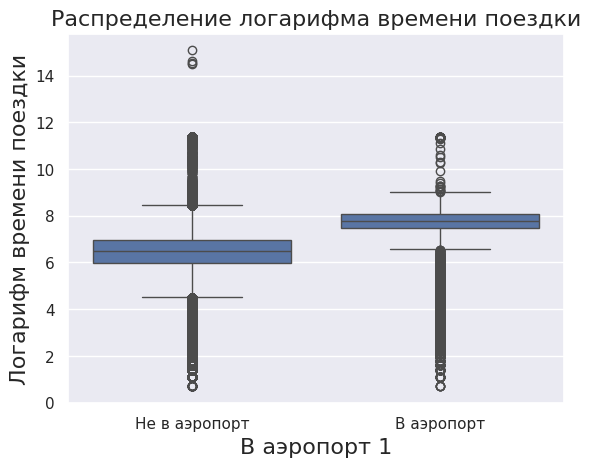

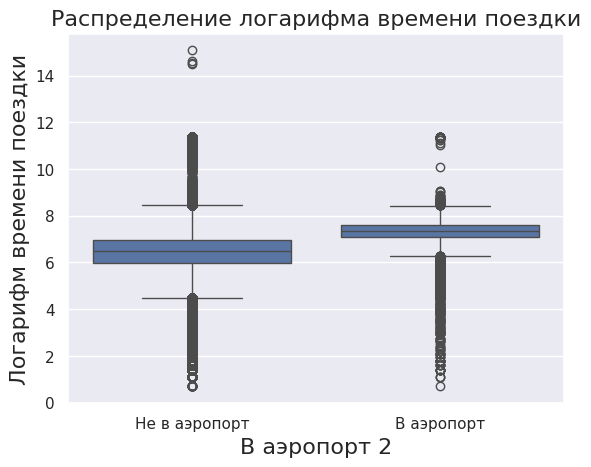

In [43]:
sns.boxplot(data=train, x="to_air1", y="log_trip_duration")
plt.xlabel('В аэропорт 1', fontsize=16)
plt.ylabel('Логaрифм времени поездки', fontsize=16)
plt.title('Распределение логарифма времени поездки', fontsize=16)
plt.xticks([0, 1], ["Не в аэропорт",  "В аэропорт"])
plt.show()

sns.boxplot(data=train, x="to_air2", y="log_trip_duration")
plt.xlabel('В аэропорт 2', fontsize=16)
plt.ylabel('Логaрифм времени поездки', fontsize=16)
plt.title('Распределение логарифма времени поездки', fontsize=16)
plt.xticks([0, 1], ["Не в аэропорт",  "В аэропорт"])
plt.show()

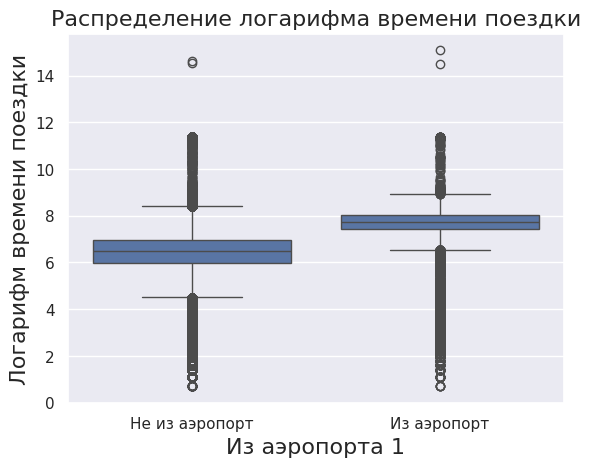

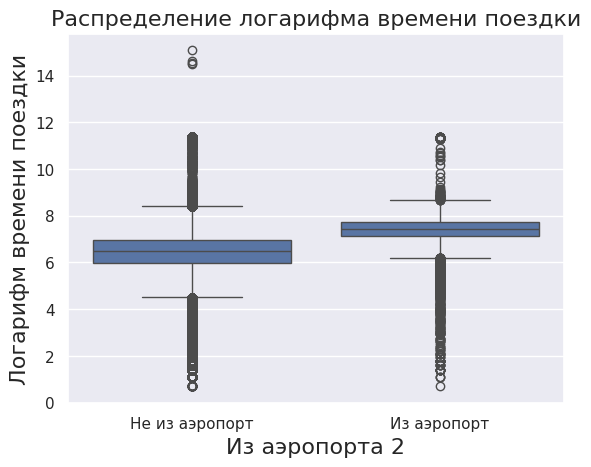

In [44]:
sns.boxplot(data=train, x="from_air1", y="log_trip_duration")
plt.xlabel('Из аэропорта 1', fontsize=16)
plt.ylabel('Логaрифм времени поездки', fontsize=16)
plt.title('Распределение логарифма времени поездки', fontsize=16)
plt.xticks([0, 1], ["Не из аэропорт",  "Из аэропорт"])
plt.show()

sns.boxplot(data=train, x="from_air2", y="log_trip_duration")
plt.xlabel('Из аэропорта 2', fontsize=16)
plt.ylabel('Логaрифм времени поездки', fontsize=16)
plt.title('Распределение логарифма времени поездки', fontsize=16)
plt.xticks([0, 1], ["Не из аэропорт",  "Из аэропорт"])
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

Да, эти признаки получиличь хорошими, так как от них зависит log_trip_duration.

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [45]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, sqr = [[40.698, -74.026], [40.801, -73.930]], cnt = 5):
        self.sqr = sqr
        self.cnt = cnt

    def show_map(self):
        # you may want to visualize cells
        m = folium.Map(location=((self.sqr[0][0] + self.sqr[1][0]) / 2, (self.sqr[0][1] + self.sqr[1][1]) / 2))
        d1 = np.linspace(self.sqr[0][0], self.sqr[1][0], self.cnt + 1)
        d2 = np.linspace(self.sqr[0][1], self.sqr[1][1], self.cnt + 1)
        for i in range(self.cnt):
            for j in range(self.cnt):
                folium.Rectangle(
                            [[d1[i], d2[j]], [d1[i+1], d2[j+1]]],
                            weight=3,
                            fill_color="green").add_to(m)
        return m
    def check(self, X1, y=None):
        X = X1.copy()
        X["pikcup_cor"] = -1
        X["lat_pickup"] = (((X["pickup_latitude"] - self.sqr[0][0]) * self.cnt) / (self.sqr[1][0] - self.sqr[0][0])).astype(int)
        X["long_pickup"] = (((X["pickup_longitude"] - self.sqr[0][1]) * self.cnt) / (self.sqr[1][1] - self.sqr[0][1])).astype(int)
        X["first_pikcup_cor"] = X["lat_pickup"]*self.cnt + X["long_pickup"]
        X.loc[(X["lat_pickup"] >= 0) & (X["lat_pickup"] <= self.cnt) &
             (X["long_pickup"] >= 0) & (X["long_pickup"] <= self.cnt),
             "pikcup_cor"] = X.loc[(X["lat_pickup"] >= 0) & (X["lat_pickup"] <= self.cnt) &
             (X["long_pickup"] >= 0) & (X["long_pickup"] <= self.cnt),
             "first_pikcup_cor"]
        X = X.drop(columns=["pickup_latitude", "pickup_longitude", "first_pikcup_cor", "long_pickup", "lat_pickup"])
        X["dropoff_cor"] = -1
        X["lat_dropoff"] = (((X["dropoff_latitude"] - self.sqr[0][0]) * self.cnt) / (self.sqr[1][0] - self.sqr[0][0])).astype(int)
        X["long_dropoff"] = (((X["dropoff_longitude"] - self.sqr[0][1]) * self.cnt) / (self.sqr[1][1] - self.sqr[0][1])).astype(int)
        X["first_dropoff_cor"] = X["lat_dropoff"]*self.cnt + X["long_dropoff"]
        X.loc[(X["lat_dropoff"] >= 0) & (X["lat_dropoff"] <= self.cnt) &
             (X["long_dropoff"] >= 0) & (X["long_dropoff"] <= self.cnt),
             "dropoff_cor"] = X.loc[(X["lat_dropoff"] >= 0) & (X["lat_dropoff"] <= self.cnt) &
             (X["long_dropoff"] >= 0) & (X["long_dropoff"] <= self.cnt),
             "first_dropoff_cor"]
        X = X.drop(columns=["dropoff_latitude", "dropoff_longitude", "first_dropoff_cor", "long_dropoff", "lat_dropoff"])
        return X

    def check2(self, X1, y=None):
        X = X1.copy()
        X["pikcup_cor"] = -1
        X["lat_pickup"] = (((X["pickup_latitude"] - self.sqr[0][0]) * self.cnt) / (self.sqr[1][0] - self.sqr[0][0])).astype(int)
        X["long_pickup"] = (((X["pickup_longitude"] - self.sqr[0][1]) * self.cnt) / (self.sqr[1][1] - self.sqr[0][1])).astype(int)
        X["first_pikcup_cor"] = X["lat_pickup"]*self.cnt + X["long_pickup"]
        X.loc[(X["lat_pickup"] >= 0) & (X["lat_pickup"] <= self.cnt) &
             (X["long_pickup"] >= 0) & (X["long_pickup"] <= self.cnt),
             "pikcup_cor"] = X.loc[(X["lat_pickup"] >= 0) & (X["lat_pickup"] <= self.cnt) &
             (X["long_pickup"] >= 0) & (X["long_pickup"] <= self.cnt),
             "first_pikcup_cor"]
        X = X.drop(columns=["first_pikcup_cor", "long_pickup", "lat_pickup"])
        X["dropoff_cor"] = -1
        X["lat_dropoff"] = (((X["dropoff_latitude"] - self.sqr[0][0]) * self.cnt) / (self.sqr[1][0] - self.sqr[0][0])).astype(int)
        X["long_dropoff"] = (((X["dropoff_longitude"] - self.sqr[0][1]) * self.cnt) / (self.sqr[1][1] - self.sqr[0][1])).astype(int)
        X["first_dropoff_cor"] = X["lat_dropoff"]*self.cnt + X["long_dropoff"]
        X.loc[(X["lat_dropoff"] >= 0) & (X["lat_dropoff"] <= self.cnt) &
             (X["long_dropoff"] >= 0) & (X["long_dropoff"] <= self.cnt),
             "dropoff_cor"] = X.loc[(X["lat_dropoff"] >= 0) & (X["lat_dropoff"] <= self.cnt) &
             (X["long_dropoff"] >= 0) & (X["long_dropoff"] <= self.cnt),
             "first_dropoff_cor"]
        X = X.drop(columns=["first_dropoff_cor", "long_dropoff", "lat_dropoff"])
        return X

    def fit(self, X=None, y=None):
        # your code here
        X1 = self.check(X)
        self.encode = OneHotEncoder(handle_unknown="ignore").fit(X1[["pikcup_cor", "dropoff_cor"]])
        return self

    def transform(self, X, y=None):
        # your code here
        X1 = self.check(X)
        return self.encode.transform(X1[["pikcup_cor", "dropoff_cor"]])


d = MapGridTransformer().check(train)
print(d[(d["pikcup_cor"] == -1) | (d["dropoff_cor"] == -1)].shape[0])
MapGridTransformer().show_map()

164080


**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [46]:
y = train["log_trip_duration"]
X = train.drop(columns=["log_trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
categorical = ["hour", "weekday", "month", "date", "situation1", "situation2", "to_air1", "to_air2", "from_air1", "from_air2", "jam", "free"]
numeric_features = ["log_haversine"]
cords = ["pickup_latitude","pickup_longitude", "dropoff_latitude", "dropoff_longitude"]

In [47]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('map', MapGridTransformer(), cords),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4712


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

vendor_id: Этот признак указывает на поставщика услуги такси. Разные поставщики могут иметь свои особенности в плане организации работы (например, различия в политике распределения заказов или маршрутизации). Некоторые поставщики могут быть более оперативны в определенных районах или более склонны к задержкам, что может повлиять на продолжительность поездки.

passenger_count: Количество пассажиров может оказывать влияние на продолжительность поездки. Например, если в машине много пассажиров, это может потребовать дополнительного времени для посадки и высадки, а также возможно, водитель будет двигаться более осторожно. Кроме того, при большом числе пассажиров возможны остановки по пути или корректировка маршрута.

store_and_fwd_flag: Этот признак показывает, отправилась ли информация о поездке сразу или была сохранена в памяти автомобиля и передана позже. Если поездка была задержана перед отправкой данных, это может быть признаком нахождения в зоне с плохим интернет-покрытием (например, в тоннелях или плотной городской застройке), что может также влиять на маршрут и время поездки.

In [48]:

print("vendor_id уникальных значений -",len(train["vendor_id"].unique()))
print("store_and_fwd_flag уникальных значений -", len(train["store_and_fwd_flag"].unique()))
print("passenger_count уникальных значений -", len(train["passenger_count"].unique()))

vendor_id уникальных значений - 2
store_and_fwd_flag уникальных значений - 2
passenger_count уникальных значений - 10


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

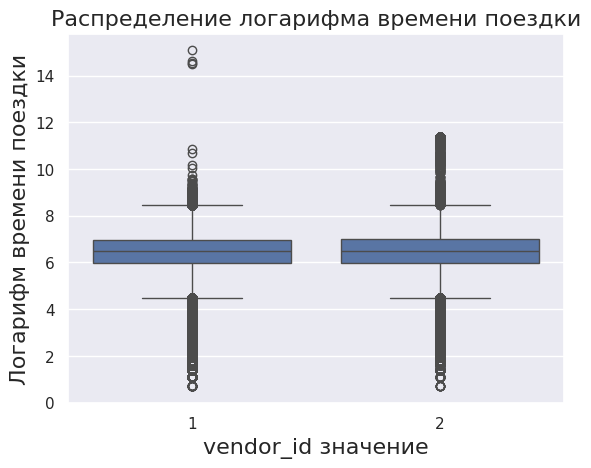

In [49]:
sns.boxplot(data=train, x="vendor_id", y="log_trip_duration")
plt.xlabel('vendor_id значение', fontsize=16)
plt.ylabel('Логарифм времени поездки', fontsize=16)
plt.title('Распределение логарифма времени поездки', fontsize=16)
plt.show()

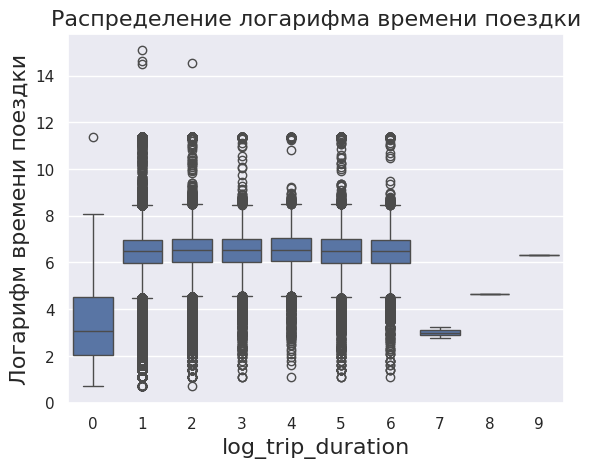

In [50]:
sns.boxplot(data=train, x="passenger_count", y="log_trip_duration")
plt.xlabel('log_trip_duration', fontsize=16)
plt.ylabel('Логарифм времени поездки', fontsize=16)
plt.title('Распределение логарифма времени поездки', fontsize=16)
plt.show()

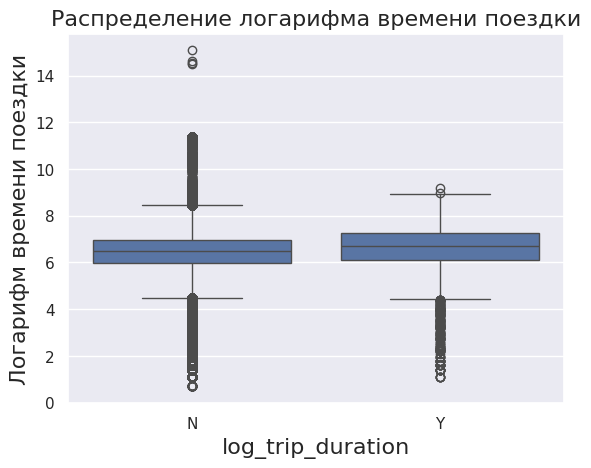

In [51]:
sns.boxplot(data=train, x="store_and_fwd_flag", y="log_trip_duration")
plt.xlabel('log_trip_duration', fontsize=16)
plt.ylabel('Логарифм времени поездки', fontsize=16)
plt.title('Распределение логарифма времени поездки', fontsize=16)
plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [52]:
train.loc[train['vendor_id'] == 2, 'vendor_id'] = 0
train.loc[train['store_and_fwd_flag'] == 'N', 'store_and_fwd_flag'] = 0
train.loc[train['store_and_fwd_flag'] == 'Y', 'store_and_fwd_flag'] = 1

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

В целом, эти признаки могут быть полезными для улучшения модели, но, вероятно, они не будут основными или самыми сильными. Основное влияние на продолжительность поездки, скорее всего, окажут признаки, связанные с расстоянием, временем суток, и, возможно, плотностью движения в зависимости от времени и местоположения.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [53]:
y = train["log_trip_duration"]
X = train.drop(columns=["log_trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
categorical = ["hour", "weekday", "month", "date", "situation1", "situation2", "to_air1", "to_air2", "from_air1", "from_air2", "jam", "free", "vendor_id", "store_and_fwd_flag"]
numeric_features = ["log_haversine", "passenger_count"]
cords = ["pickup_latitude","pickup_longitude", "dropoff_latitude", "dropoff_longitude"]

In [54]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('map', MapGridTransformer(), cords),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4710


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

In [55]:
train = train.drop(columns = ["vendor_id", "store_and_fwd_flag", "passenger_count"])
df = train.copy()

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [57]:
X_train, X_test = train_test_split(train, test_size=0.3, random_state=10)

In [56]:
categorical = ["hour", "weekday", "month", "date", "situation1", "situation2", "to_air1", "to_air2", "from_air1", "from_air2", "jam", "free"]
numeric_features = ["log_haversine"]
cords = ["pickup_latitude","pickup_longitude", "dropoff_latitude", "dropoff_longitude"]

In [59]:
y_train = X_train["log_trip_duration"]

In [58]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('map', MapGridTransformer(), cords),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_train)
X_train['dif'] = y_train - y_pred

In [60]:
X_train = X_train[(X_train["dif"] < 2) & (X_train["dif"] > -2) &
        (X_train["log_haversine"] < 3.5) & (X_train["log_trip_duration"] > 3)]

In [61]:
X_train = X_train.drop("dif", axis = 1)

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

In [62]:
y_train = X_train["log_trip_duration"]
X_train = X_train.drop(columns=["log_trip_duration"])
y_test = X_test["log_trip_duration"]
X_test = X_test.drop(columns=["log_trip_duration"])

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [63]:

categorical = ["hour", "weekday", "month", "date", "situation1", "situation2", "to_air1", "to_air2", "from_air1", "from_air2", "jam", "free"]
numeric_features = ["log_haversine"]
cords = ["pickup_latitude","pickup_longitude", "dropoff_latitude", "dropoff_longitude"]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="infrequent_if_exist", max_categories = 1000, min_frequency=0.0005), categorical),
    ('map', MapGridTransformer(), cords),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4714


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [65]:
from sklearn.preprocessing import OneHotEncoder
encode = OneHotEncoder(handle_unknown="infrequent_if_exist", max_categories = 1000, min_frequency=0.0005)
encode.fit(X_train[categorical])
map_code = MapGridTransformer()
map_code.fit(X_train[cords])
print('Количество признаков после кодирования категориальных:', len(categorical) + len(cords) + len(numeric_features))
print('Количество признаков после кодирования категориальных:', encode.transform(X_train[categorical]).shape[1] + map_code.transform(X_train[cords]).shape[1] + len(numeric_features))

Количество признаков после кодирования категориальных: 17
Количество признаков после кодирования категориальных: 300


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [66]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="infrequent_if_exist", max_categories = 1000, min_frequency=0.0005), categorical),
    ('map', MapGridTransformer(), cords),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.7943


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Как будто бы Ridge-регрессия лучше, так как там ошибка меньше

Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [67]:
A_train = X_train.copy()
b_train = y_train.copy()
A_test = X_test.copy()
b_test = y_test.copy()

In [68]:
X_train, X_alph, y_train, y_alph = train_test_split(X_train, y_train, test_size=0.2, random_state=10)
alphas = np.logspace(-4, 4, 20)

In [69]:
categorical = ["hour", "weekday", "month", "date", "situation1", "situation2", "to_air1", "to_air2", "from_air1", "from_air2", "jam", "free"]
numeric_features = ["log_haversine"]
cords = ["pickup_latitude","pickup_longitude", "dropoff_latitude", "dropoff_longitude"]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="infrequent_if_exist", max_categories = 1000, min_frequency=0.0005), categorical),
    ('map', MapGridTransformer(), cords),
    ('scaling', StandardScaler(), numeric_features)
])


In [71]:
from sklearn.model_selection import GridSearchCV

zeros_ridge = []
err_ridge = 100000000.0
alpha_ridge = None
errors_ridge = []
for alpha in alphas:
    ridge_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(alpha=alpha))
    ])
    model = ridge_pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_alph)
    err =  mean_squared_error(y_alph, y_pred, squared=False)
    zeros_ridge.append(sum(ridge_pipeline.steps[-1][-1].coef_ == 0))
    errors_ridge.append(err)
    if err < err_ridge:
        err_ridge = err
        alpha_ridge = alpha

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

In [72]:
zeros_losso = []
err_losso = 100000000.0
alpha_losso = None
errors_losso = []
for alpha in alphas:
    losso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(alpha=alpha))
    ])
    model = losso_pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_alph)
    err =  mean_squared_error(y_alph, y_pred, squared=False)
    zeros_losso.append(sum(losso_pipeline.steps[-1][-1].coef_ == 0))
    errors_losso.append(err)
    if err < err_losso:
        err_losso = err
        alpha_losso = alpha

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'roo

In [73]:
print("Минимальная ошибка Lasso:", err_losso)
print("Минимальная ошибка Ridge:", err_ridge)
print("Лучшая альфа для Lasso:", alpha_ridge)
print("Лучшая альфа для Ridge:", alpha_losso)

Минимальная ошибка Lasso: 0.4019130137636557
Минимальная ошибка Ridge: 0.4015111940619963
Лучшая альфа для Lasso: 0.0001
Лучшая альфа для Ridge: 0.0001


Сохраните наилучшее значение, как бенчмарк на будущее

In [74]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
best_rmsle = 0.4015111940619963

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

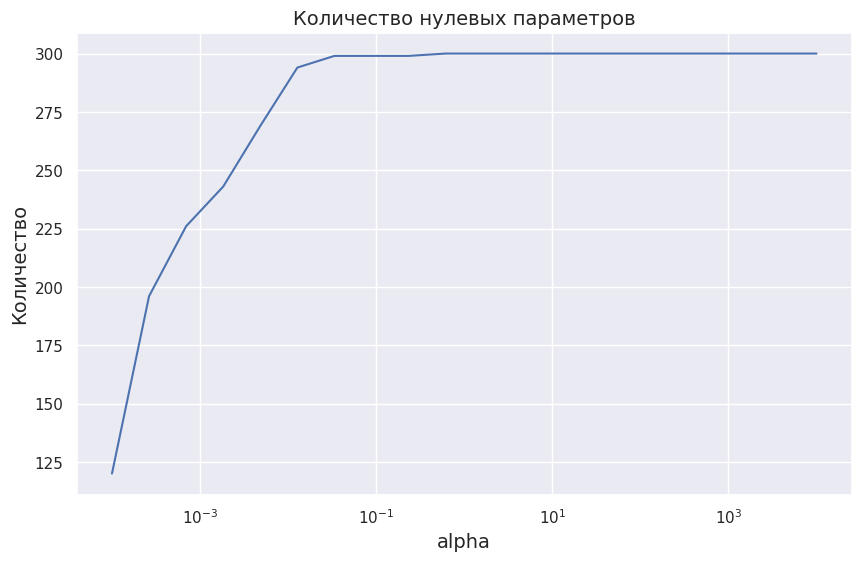

In [75]:
plt.figure(figsize = (10, 6))
plt.plot(alphas, zeros_losso)
plt.title("Количество нулевых параметров", fontsize=14)
plt.xlabel("alpha", fontsize=14)
plt.ylabel("Количество", fontsize=14)
plt.xscale("log")
plt.show()

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

Такой признак потенциально полезен, потому что он позволяет зафиксировать популярные направления поездок, которые могут отражать ключевые маршруты с устойчивыми паттернами спроса. Вместо того чтобы модель самостоятельно выявляла закономерности между отдельными ячейками начала и конца поездки, добавление частых пар в виде категориального признака сокращает сложность задачи. Это позволяет модели сразу использовать информацию о популярных направлениях и улучшить предсказание для частых маршрутов.

Линейная модель не может самостоятельно "вытащить" эту информацию, так как взаимодействие между началом и концом поездки требует нелинейных зависимостей, которые линейная модель не может учесть напрямую. Закодированные пары облегчают использование информации о популярных маршрутах в рамках ограничений линейной модели, поскольку она теперь может различать их, не строя сложные взаимодействия.

In [76]:
B = A_train.copy()
map_code = MapGridTransformer()
map_code.fit(A_train)
A_train= map_code.check2(A_train)
A_train['way'] = A_train['pikcup_cor'] + A_train['dropoff_cor'] * 1000 # уникальность
A_train

,id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,date,weekday,hour,month,...,speed,jam,free,to_air1,from_air1,to_air2,from_air2,pikcup_cor,dropoff_cor,way
824746,id2365163,2016-03-27 00:25:29,-73.996986,40.742210,-73.987740,40.710659,2016-03-27,6,00,03,...,0.002866,1,0,0,0,0,0,11,1,1011
645821,id3126187,2016-03-18 20:44:12,-73.989929,40.741760,-73.977280,40.783600,2016-03-18,4,20,03,...,0.004920,1,0,0,0,0,0,11,22,22011
691846,id2588127,2016-04-15 18:26:12,-73.972366,40.750725,-73.861832,40.768387,2016-04-15,4,18,04,...,0.004566,1,0,0,0,1,0,12,-1,-988
1147931,id0915715,2016-03-24 14:28:34,-73.982361,40.776901,-73.975128,40.760921,2016-03-24,3,14,03,...,0.001917,0,0,0,0,0,0,17,17,17017
183569,id3758776,2016-04-28 13:53:52,-73.973778,40.764374,-73.966957,40.761024,2016-04-28,3,13,04,...,0.001423,0,0,0,0,0,0,17,18,18017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804336,id1857258,2016-05-08 14:05:00,-73.987877,40.738491,-73.950821,40.774704,2016-05-08,6,14,05,...,0.004015,0,0,0,0,0,0,6,18,18006
1348317,id2763967,2016-05-12 05:16:06,-73.996178,40.748222,-73.990967,40.755478,2016-05-12,3,05,05,...,0.005103,0,1,0,0,0,0,11,11,11011
617841,id2242904,2016-03-21 20:11:12,-73.960091,40.779701,-73.960136,40.773102,2016-03-21,0,20,03,...,0.004860,1,0,0,0,0,0,18,18,18018
1048548,id2558617,2016-04-09 09:21:44,-73.968124,40.799923,-73.952415,40.818588,2016-04-09,5,09,04,...,0.005644,0,1,0,0,0,0,23,28,28023


In [77]:
X_train, X_test, y_train, y_test = train_test_split(A_train, b_train, test_size=0.2, random_state=10)

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [78]:
categorical = ["hour", "weekday", "month", "date", "situation1", "situation2", "to_air1", "to_air2", "from_air1", "from_air2", "jam", "free"]
numeric_features = ["log_haversine"]
cords = ["pickup_latitude","pickup_longitude", "dropoff_latitude", "dropoff_longitude"]

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="infrequent_if_exist", max_categories = 1000, min_frequency=0.0005), categorical),
    ('map', MapGridTransformer(), cords),
    ('scaling', StandardScaler(), numeric_features),
    ('ohe_way', OneHotEncoder(handle_unknown="infrequent_if_exist", max_categories=101), ['way'])
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(alpha_ridge))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.3897


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут).

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**.

Разумеется, погружаться в feature engineering можно ещё очень долго. Ваша задача - придумать какие-то новые признаки, которые сделают модель ещё лучше!! За улучшение функционала ошибки на каждые 0.005 на тестовой выборке относительно `best_rmsle` будет даваться 0.5 бонусных балла. Всего за этот пункт можно получить до 2 бонусных баллов.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Какие могут быть идеи для вдохновения:

1. Трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения, по аналогии с квадратной сеткой  
> Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.    

2. Мы пока что никак не использовали историчность и взаимосвязь в данных, хотя информация о том, что было ранее в эти/похожие дни тоже может пригодиться. Попробуйте поискать соседей и/или построить агрегации, например, при помощи groupby, посчитайте какие-либо статистики в пределах какого-то окна (подберите всё это сами, постарайтесь, чтобы это было что-то разумное), и присоедините к основному датафрейму
> Важно: учтите, что разных вариантов агрегаций и статистик существует очень много. Не стесняйтесь выкидывать фичи, которые вам не нравятся (помните про свойство Lasso), используйте эффективные способы хранения данных ([wink](https://www.kaggle.com/code/demche/polars-memory-usage-optimization)-[wink](https://docs.scipy.org/doc/scipy/reference/sparse.html))

3. В конце концов можно использовать альтернативные способы преобразования данных. Например, использовать другой scaler, другую кодировку категориальных фичей, другие гиперпараметры и пр. Но помните, что на данный момент мы ограничены только `Ridge` и `Lasso`

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.